# <center> EVOLUTIONARY COMPUTATION 
## <center> EVOLUTION OF NEURAL NETWORKS
<center>
<img src="../imgs/logo.png" width="30%"></center>

<center> Paul Templier - paul.templier@isae-supaero.fr

## Motivation

<center><img src="../imgs/agent_representations.png" width="50%">

<!-- $\pi: s\rightarrow a$ -->

## Evolution of neural networks

<center><img src="../imgs/intro_neuroevolution.png" width="50%">

*Miikkulainen, Risto. "Evolution of neural networks." Proceedings of the Genetic and Evolutionary Computation Conference Companion. 2017*

## Neural Networks

### Neuron model
<center><img src="../imgs/neuron.jpg" width="50%">


### Artificial neuron

<center><img src="../imgs/neuron_model.jpeg" width="50%">

<center>cs231n.github.io

<!-- $f(\sum_{i}{w_i x_i} +b)$ -->

$w_i$: weights  
$x_i$: output of previous neurons  
$b$: bias  
$f$: activation function to break linearity 




### Artificial Neural Network
<center><img src="../imgs/neural_network.png" width="50%">
    
    
$(y_1 ... y_n) = F(x_1 ... x_m)$
    
    
*Source: https://medium.com/swlh/neural-networks-4b6f719f9d75*

## <center> Exercise </center>
<br>  
<center> Break into groups and discuss: </center>
<br>
<center>What do we need in the genome to optimize a neural network? How would you encode it? </center>
<br>
<center>Can you find mutation and crossover operators on your encoding?</center>

# <center> NEUROEVOLUTION </center>

<center><img src="../imgs/cellular_encoding.png" width="60%">

Gruau, Frederic, and Darrell Whitley. "Adding learning to the cellular development of neural networks: Evolution and the Baldwin effect." Evolutionary computation 1.3 (1993): 213-233. 

<center><img src="../imgs/barr.png" width="50%">

Fleischer, Kurt, and Alan H. Barr. "A simulation testbed for the study of multicellular development: The multiple mechanisms of morphogenesis." 1994 

# <center> NeuroEvolution of Augmenting Topologies (NEAT) </center>

<center><img src="../imgs/neat_encoding.png" width="60%">
        
Stanley, Kenneth O., and Risto Miikkulainen. "Evolving neural networks through augmenting topologies." Evolutionary computation 10.2 (2002): 99-127 

    
Stanley, Kenneth O., and Risto Miikkulainen. "Evolving neural networks through augmenting topologies." Evolutionary computation 10.2 (2002): 99-127 

# <center> NEUROEVOLUTION: FIXED ARCHITECTURE </center>

<center><img src="../imgs/ne_basics.png" width="50%">

Miikkulainen, Risto. "Evolution of neural networks." Proceedings of the Genetic and Evolutionary Computation Conference Companion. 2017. 

# <center> PROBLEMS WITH NEUROEVOLUTION </center>

<center><img src="../imgs/ne_problems.png" width="40%">

Miikkulainen, Risto. "Evolution of neural networks." Proceedings of the Genetic and Evolutionary Computation Conference Companion. 2017. 

# <center> INDIRECT ENCODING </center>

<center><img src="../imgs/encoding.png" width="50%">
    


# <center> HyperNEAT </center>

<center><img src="../imgs/indirect_hyperneat.png" width="50%">

<center><img src="../imgs/hyperneat.png" width="50%">
    
Stanley, Kenneth O.; D'Ambrosio, David B.; Gauci, Jason (2009-01-14). "A Hypercube-Based Encoding for Evolving Large-Scale Neural Networks". Artificial Life journal 15(2), Cambridge, MA: MIT Press, 2009

# <center> GENE: Geometric Encoding for NeuroEvolution </center>

<center><img src="../imgs/indirect_transform.png" width="50%">
   

<center><img src="../imgs/coordsnet_coordinates.png" width="40%">

<center><img src="../imgs/coordsnet_graph.png" width="50%">

*Paul Templier, Emmanuel Rachelson, and Dennis G. Wilson. 2021. A Geometric Encoding for Neural Network Evolution. In 2021 Genetic and Evolutionary Computation Conference (GECCO ’21), July 10–14, 2021, Lille, France. ACM, New York, NY, USA, 9 pages. https://doi.org/10.1145/3449639.3459361*

# Notebook

In [1]:
using Pkg
pkg"add PyCall Flux Plots Random Statistics ArcadeLearningEnvironment Reel Images ImageView"

   Updating registry at `~/.julia/registries/General`
######################################################################### 100,0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [7]:
using PyCall
using Flux
using Plots
using Random
using Statistics

In [8]:
gym = pyimport("gym")

PyObject <module 'gym' from '/home/disc/p.templier/miniconda3/lib/python3.8/site-packages/gym/__init__.py'>

## Gym CartPole

<img src="../imgs/cartpole.gif" width="50%">

https://github.com/adibyte95/CartPole-OpenAI-GYM/blob/master/gif%20images/reinforcement-gif.gif

In [9]:
mutable struct Individual
    genes::Array{Float64}
    fitness::Float64
    layers::Array{Int64}
    model
end

function Individual(layers::Array, genes::Array{Float64})
    model = make_network(layers)
    
    ind = Individual(genes, -Inf, layers, model)
    
    set_weights!(ind) 
    ind
end

function Individual(layers::Array)
    model = make_network(layers)
    
    param_lengths = [length(p) for p in params(model)]
    genes = rand(sum(param_lengths))
    
    ind = Individual(genes, -Inf, layers, model)
    set_weights!(ind)  
    ind
end

Individual

In [10]:
function set_weights!(ind::Individual)    
    start = 1
    for p in params(ind.model)
        p .= reshape(ind.genes[start:(start+length(p)-1)], size(p))
        start += length(p)
    end
    ind
end

function make_network(layers::Array)
    l = []
    for i in 1:length(layers)-1
        d = Dense(layers[i], layers[i+1], Flux.relu)
        push!(l, d)
    end
    Chain(l...)
end

function mutate(ind::Individual; 
        mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = rand()
        end
    end
    Individual(ind.layers, new_genes)
end

mutate (generic function with 1 method)

## Cartpole

In [11]:
function play_cartpole(ind::Individual, render=false)
    env_name="CartPole-v1"
    env = gym.make(env_name)
    env.seed(0)
    obs = env.reset()
    total_reward = 0.0
    done = false
    for i in 1:200
        action = ind.model(obs)
        action = argmax(action) - 1
        
        obs, reward, done, _ = env.step(action)
        if render
            env.render(mode="human")
        end
        total_reward += reward
    end
    env.close()
    total_reward
end

function evaluate!(ind::Individual, objective::Function)
    ind.fitness = objective(ind)
end

evaluate! (generic function with 1 method)

In [15]:
layers = [4, 16, 16, 2]
ind = Individual(layers)
n = length(ind.genes)
n_gens = Int(round(n * log(n)))

2299

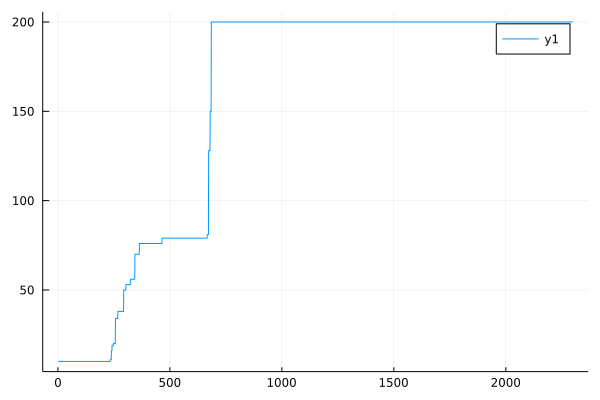

In [16]:
fits, parent = one_plus_one(layers, n_gens, play_cartpole)
plot(fits)

## 1+$\lambda$ EA

In [19]:
function one_plus_lambda(layers::Array, num_generations::Int, f::Function, 𝜆::Int)

    fits = zeros(num_generations)
    expert = Individual(layers::Array)
    evaluate!(expert, f)

    for i in eachindex(fits)
        population = Array{Individual}(undef, 𝜆)
        best = 1
        for j in eachindex(population)
            population[j] = mutate(expert)
            evaluate!(population[j], f)
            if population[j].fitness > population[best].fitness
                best = j
            end
        end

        if population[best].fitness >= expert.fitness
            expert = population[best]
        end

        fits[i] = expert.fitness
        print(i, "/",  num_generations, " > ", expert.fitness, "\t\t\r")
    end
    fits, expert
end


one_plus_lambda (generic function with 1 method)

In [20]:
𝜆=5
layers = [4, 16, 16, 2]
ind = Individual(layers)
n = length(ind.genes)
n_gens = Int(round(n * log(n) / 𝜆))

460

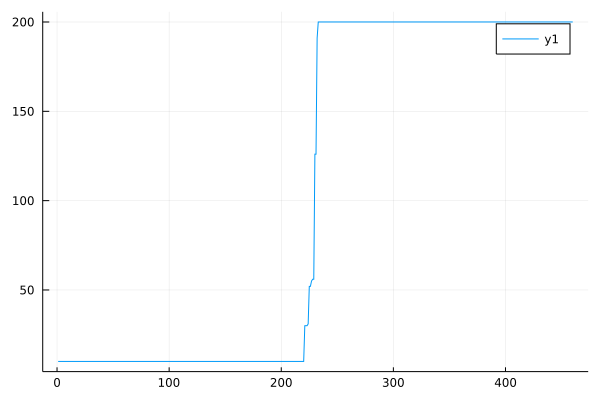

In [31]:
fits, expert = one_plus_lambda(layers, n_gens, play_cartpole, 𝜆)
plot(fits)

## Evolutionary Strategies

In [26]:
using Statistics
using LinearAlgebra

function ES(layers::Array, num_generations::Int, f::Function, npop::Int=50, sigma=0.5, alpha=0.01)
    µ = Individual(layers::Array) # Center
    n = length(µ.genes)
    evaluate!(µ, f)

    expert = µ # Best individual so far

    fits = zeros(num_generations)

    for i in eachindex(fits)
        population = Array{Individual}(undef, 𝜆)
        best = 1
        for j in eachindex(population)
            new_genes = expert.genes + randn(n) .* sigma
            population[j] = Individual(layers, new_genes)
            evaluate!(population[j], f)
            if population[j].fitness > population[best].fitness
                best = j
            end
        end

        if population[best].fitness >= expert.fitness
            expert = population[best]
        end

        fits[i] = expert.fitness

        # TODO: µ update

        print(i, "/",  num_generations, " > ", expert.fitness, "\t\t\r")
    end
    fits, expert
end


ES (generic function with 4 methods)

In [5]:
## Uncomment and run the next line to load a solution 
# IJulia.load("solutions/es.jl") 

In [27]:
layers = [4, 16, 16, 2]
ind = Individual(layers)
n = length(ind.genes)

386

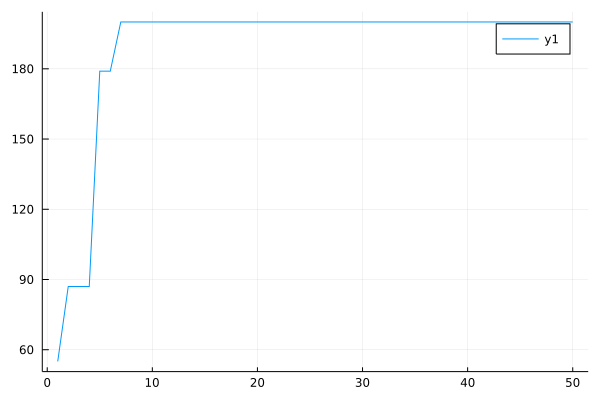

In [28]:
fits, expert = ES(layers, 50, play_cartpole, 5)
plot(fits)

In [98]:
play_cartpole(expert, true)

200.0